Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)


This tutorial demonstrates how to construct a training workflow of UNETR [1] on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kidney 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1]:

[1]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb)

## Setup environment

In [1]:
import matplotlib 
%matplotlib inline

## Setup imports

In [2]:
# 필요한 모듈들을 임포트
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from tqdm import tqdm

# MONAI에서 제공하는 손실함수와 추론 메서드 임포트
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference

# 데이터 변환에 필요한 클래스 임포트
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

# MONAI 구성 및 성능 지표 클래스 임포트
from monai.config import print_config
from monai.metrics import DiceMetric

# MONAI에서 제공하는 UNETR 네트워크 모델 임포트
from monai.networks.nets import UNETR

# 데이터 로딩 및 캐싱에 필요한 클래스 임포트
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 파이토치 임포트
import torch

# MONAI 구성 출력
print_config()

/home/hyoreek/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.2+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu102
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpyoi6txjf


## Setup transforms for training and validation

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

In [5]:
data_dir = "../../dataset/hyoreek/dataset/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


## Check data shape and visualize

../../dataset/hyoreek/dataset/imagesTr/img0035.nii.gz
image shape: (1, 314, 214, 234), label shape: (1, 314, 214, 234)


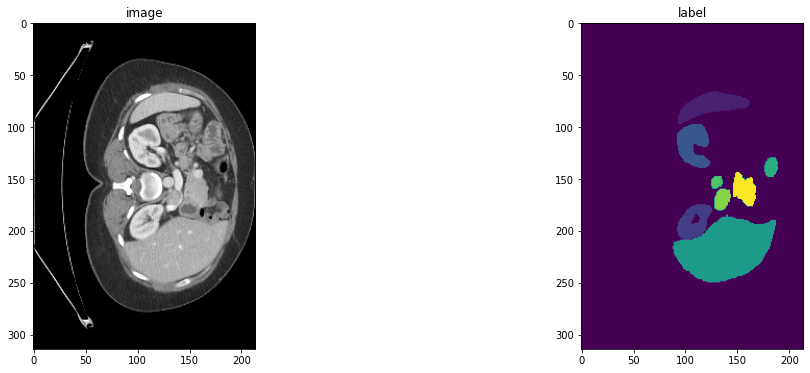

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
# img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
file_path = val_ds[case_num]['image_meta_dict']['filename_or_obj']
print(file_path)
img_name = os.path.basename(file_path)

img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]])
plt.show()

{
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        // 이미지 이름을 적절히 수정해주셔야 합니다.
    ],
    "training": [
        {
            "image": "imagesTr/DET0000301_avg.nii.gz",
            "label": "labelsTr/DET0000101_avg_seg.nii.gz"
        },
        {
            "image": "imagesTr/DET0000601_avg.nii.gz",
            "label": "labelsTr/DET0000201_avg_seg.nii.gz"
        },
        // 이하 생략, 나머지도 이런 식으로 작성
    ],
    "validation": [
        {
            "image": "imagesTr/DET0000701_avg.nii.gz",
            "label": "labelsTr/DET0000801_avg_seg.nii.gz"
        },
        {
            "image": "imagesTr/DET0007301_avg.nii.gz",
            "label": "labelsTr/DET0001101_avg_seg.nii.gz"
        },
        // 이하 생략, 나머지도 이런 식으로 작성
    ]
}


{
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        // 이미지 이름을 적절히 수정해주셔야 합니다.
    ],
    "training": [
        {
            "image": "imagesTr/DET0000301_avg.nii.gz",
            "label": "labelsTr/DET0000101_avg_seg.nii.gz"
        },
        {
            "image": "imagesTr/DET0000601_avg.nii.gz",
            "label": "labelsTr/DET0000201_avg_seg.nii.gz"
        },
        // 이하 생략, 나머지도 이런 식으로 작성
    ],
    "validation": [
        {
            "image": "imagesTr/DET0000701_avg.nii.gz",
            "label": "labelsTr/DET0000801_avg_seg.nii.gz"
        },
        {
            "image": "imagesTr/DET0007301_avg.nii.gz",
            "label": "labelsTr/DET0001101_avg_seg.nii.gz"
        },
        // 이하 생략, 나머지도 이런 식으로 작성
    ]
}


In [7]:
import os
import glob
from monai.transforms import LoadImaged, AddChanneld, ScaleIntensityd, RandGaussianNoised
from monai.data import CacheDataset, DataLoader
from monai.utils import set_determinism
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### Create Model, Loss, Optimizer


In [8]:
import torch
import torch.nn as nn
from monai.networks.nets import UNETR


model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join('.', "best_metric_model_20230816_30000.pth"))

                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000 #25000 #27000
# 보고서
# 조건을 계속해서 바꿔보면서 어떨 때 segmentation이 제일 잘 되더라,,
# 특정 dataset인 것이니(medical data), 데이터의 특성상 기존 benchmark와 다르게,
# 어떤 조건일 때 제일 학습이 잘 되더라 ~ 느낌으로 가야해요.
# 그래서 보고서 'experiment' 항목에 여러 가지 실험을 거쳐서
# 이 여러 hyperparameter 중 어떤 조건일 때가 제일 결과가 잘 나오더라 !
# ex. iteration = 27000, eval_num = 500, ...
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join('.', "best_metric_model_20230814.pth")))

Training (500 / 30000 Steps) (loss=1.85066):  88%|████████▊ | 21/24 [00:28<00:14,  4.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10430439561605453 Current Avg. Dice: 0.10430439561605453


Training (1000 / 30000 Steps) (loss=1.41375):  71%|███████   | 17/24 [00:25<00:33,  4.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1307261735200882 Current Avg. Dice: 0.1307261735200882


Training (1500 / 30000 Steps) (loss=1.49916):  54%|█████▍    | 13/24 [00:22<00:52,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.13216473162174225 Current Avg. Dice: 0.13216473162174225


Training (2000 / 30000 Steps) (loss=1.12625):  38%|███▊      | 9/24 [00:20<01:14,  5.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1455538272857666 Current Avg. Dice: 0.1455538272857666


Training (2500 / 30000 Steps) (loss=1.16261):  21%|██        | 5/24 [00:18<01:48,  5.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.15324781835079193 Current Avg. Dice: 0.15324781835079193


Training (3000 / 30000 Steps) (loss=1.11692):   4%|▍         | 1/24 [00:15<05:59, 15.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1676572561264038 Current Avg. Dice: 0.1676572561264038


Training (3500 / 30000 Steps) (loss=1.25306):  88%|████████▊ | 21/24 [00:27<00:14,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1949024200439453 Current Avg. Dice: 0.1949024200439453


Training (4000 / 30000 Steps) (loss=1.27950):  71%|███████   | 17/24 [00:25<00:33,  4.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2711106240749359 Current Avg. Dice: 0.2711106240749359


Training (4500 / 30000 Steps) (loss=1.00958):  54%|█████▍    | 13/24 [00:22<00:52,  4.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29326629638671875 Current Avg. Dice: 0.29326629638671875


Training (5000 / 30000 Steps) (loss=1.10102):  38%|███▊      | 9/24 [00:20<01:14,  4.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3228659927845001 Current Avg. Dice: 0.3228659927845001


Training (5500 / 30000 Steps) (loss=1.08591):  21%|██        | 5/24 [00:18<01:50,  5.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3464120328426361 Current Avg. Dice: 0.3464120328426361


Training (6000 / 30000 Steps) (loss=1.10788):   4%|▍         | 1/24 [00:17<06:32, 17.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.39188602566719055 Current Avg. Dice: 0.39188602566719055


Training (6500 / 30000 Steps) (loss=1.08370):  88%|████████▊ | 21/24 [00:27<00:14,  4.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.40322017669677734 Current Avg. Dice: 0.40322017669677734


Training (7000 / 30000 Steps) (loss=0.93648):  71%|███████   | 17/24 [00:24<00:31,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.40322017669677734 Current Avg. Dice: 0.39734911918640137


Training (7500 / 30000 Steps) (loss=1.02868):  54%|█████▍    | 13/24 [00:22<00:50,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.40322017669677734 Current Avg. Dice: 0.4027663767337799


Training (8000 / 30000 Steps) (loss=1.06481):  38%|███▊      | 9/24 [00:20<01:14,  4.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4111802875995636 Current Avg. Dice: 0.4111802875995636


Training (8500 / 30000 Steps) (loss=0.98196):  21%|██        | 5/24 [00:18<01:49,  5.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42738547921180725 Current Avg. Dice: 0.42738547921180725


Training (9000 / 30000 Steps) (loss=0.86139):   4%|▍         | 1/24 [00:15<06:05, 15.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.43000873923301697 Current Avg. Dice: 0.43000873923301697


Training (9500 / 30000 Steps) (loss=0.92708):  88%|████████▊ | 21/24 [00:27<00:14,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48594895005226135 Current Avg. Dice: 0.48594895005226135


Training (10000 / 30000 Steps) (loss=0.88254):  71%|███████   | 17/24 [00:25<00:33,  4.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5635433793067932 Current Avg. Dice: 0.5635433793067932


Training (10500 / 30000 Steps) (loss=0.83617):  54%|█████▍    | 13/24 [00:23<00:53,  4.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6014114022254944 Current Avg. Dice: 0.6014114022254944


Training (11000 / 30000 Steps) (loss=0.72689):  38%|███▊      | 9/24 [00:20<01:14,  4.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6085138320922852 Current Avg. Dice: 0.6085138320922852


Training (11500 / 30000 Steps) (loss=0.93632):  21%|██        | 5/24 [00:18<01:50,  5.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6205546855926514 Current Avg. Dice: 0.6205546855926514


Training (12000 / 30000 Steps) (loss=0.94353):   4%|▍         | 1/24 [00:16<06:18, 16.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6524679660797119 Current Avg. Dice: 0.6524679660797119


Training (12500 / 30000 Steps) (loss=0.68406):  88%|████████▊ | 21/24 [00:28<00:14,  4.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6566911935806274 Current Avg. Dice: 0.6566911935806274


Training (13000 / 30000 Steps) (loss=0.79417):  71%|███████   | 17/24 [00:25<00:34,  4.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6675369739532471 Current Avg. Dice: 0.6675369739532471


Training (13500 / 30000 Steps) (loss=0.75053):  54%|█████▍    | 13/24 [00:23<00:53,  4.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6796724200248718 Current Avg. Dice: 0.6796724200248718


Training (14000 / 30000 Steps) (loss=0.83022):  38%|███▊      | 9/24 [00:20<01:14,  4.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.693595826625824 Current Avg. Dice: 0.693595826625824


Training (14500 / 30000 Steps) (loss=0.66557):  21%|██        | 5/24 [00:18<01:49,  5.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.703741729259491 Current Avg. Dice: 0.703741729259491


Training (15000 / 30000 Steps) (loss=0.81346):   4%|▍         | 1/24 [00:16<06:15, 16.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7074517607688904 Current Avg. Dice: 0.7074517607688904


Training (15500 / 30000 Steps) (loss=0.63257):  88%|████████▊ | 21/24 [00:27<00:14,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7084811329841614 Current Avg. Dice: 0.7084811329841614


Training (16000 / 30000 Steps) (loss=1.33424):  71%|███████   | 17/24 [00:25<00:33,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7221896648406982 Current Avg. Dice: 0.7221896648406982


Training (16500 / 30000 Steps) (loss=0.77937):  54%|█████▍    | 13/24 [00:21<00:50,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7221896648406982 Current Avg. Dice: 0.7220690846443176


Training (17000 / 30000 Steps) (loss=0.58959):  38%|███▊      | 9/24 [00:19<01:10,  4.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7221896648406982 Current Avg. Dice: 0.7182507514953613


Training (17500 / 30000 Steps) (loss=0.73973):  21%|██        | 5/24 [00:18<01:49,  5.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7353699207305908 Current Avg. Dice: 0.7353699207305908


Training (18000 / 30000 Steps) (loss=0.51977):   4%|▍         | 1/24 [00:16<06:16, 16.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7378007769584656


Training (18500 / 30000 Steps) (loss=0.83230):  88%|████████▊ | 21/24 [00:27<00:13,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7233017086982727


Training (19000 / 30000 Steps) (loss=0.81328):  71%|███████   | 17/24 [00:24<00:31,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7353682518005371


Training (19500 / 30000 Steps) (loss=0.60809):  54%|█████▍    | 13/24 [00:22<00:50,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7158629298210144


Training (20000 / 30000 Steps) (loss=0.73055):  38%|███▊      | 9/24 [00:20<01:10,  4.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7372958064079285


Training (20500 / 30000 Steps) (loss=0.70815):  21%|██        | 5/24 [00:17<01:44,  5.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7378007769584656 Current Avg. Dice: 0.7197677493095398


Training (21000 / 30000 Steps) (loss=0.64464):   4%|▍         | 1/24 [00:16<06:18, 16.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7387893795967102 Current Avg. Dice: 0.7387893795967102


Training (21500 / 30000 Steps) (loss=0.74495):  88%|████████▊ | 21/24 [00:27<00:13,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7387893795967102 Current Avg. Dice: 0.7367947697639465


Training (22000 / 30000 Steps) (loss=0.95724):  71%|███████   | 17/24 [00:24<00:31,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7387893795967102 Current Avg. Dice: 0.7028276920318604


Training (22500 / 30000 Steps) (loss=0.63431):  54%|█████▍    | 13/24 [00:22<00:50,  4.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7387893795967102 Current Avg. Dice: 0.7374822497367859


Training (23000 / 30000 Steps) (loss=0.70914):  38%|███▊      | 9/24 [00:21<01:15,  5.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7548649907112122 Current Avg. Dice: 0.7548649907112122


Training (23500 / 30000 Steps) (loss=0.71937):  21%|██        | 5/24 [00:18<01:50,  5.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.772807776927948 Current Avg. Dice: 0.772807776927948


Training (24000 / 30000 Steps) (loss=0.77665):   4%|▍         | 1/24 [00:16<06:14, 16.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7735994458198547 Current Avg. Dice: 0.7735994458198547


Training (24500 / 30000 Steps) (loss=0.89808):  88%|████████▊ | 21/24 [00:27<00:13,  4.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7735994458198547 Current Avg. Dice: 0.7560561299324036


Training (25000 / 30000 Steps) (loss=0.77665):  71%|███████   | 17/24 [00:25<00:33,  4.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7743696570396423 Current Avg. Dice: 0.7743696570396423


Training (25500 / 30000 Steps) (loss=0.72918):  54%|█████▍    | 13/24 [00:23<00:53,  4.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7911171913146973


Training (26000 / 30000 Steps) (loss=0.45819):  38%|███▊      | 9/24 [00:20<01:11,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7868929505348206


Training (26500 / 30000 Steps) (loss=0.45759):  21%|██        | 5/24 [00:17<01:43,  5.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7850268483161926


Training (27000 / 30000 Steps) (loss=0.69215):   4%|▍         | 1/24 [00:15<06:01, 15.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.790436327457428


Training (27500 / 30000 Steps) (loss=0.74961):  88%|████████▊ | 21/24 [00:26<00:13,  4.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7649059295654297


Training (28000 / 30000 Steps) (loss=0.72074):  71%|███████   | 17/24 [00:25<00:32,  4.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7773945331573486


Training (28500 / 30000 Steps) (loss=0.69074):  54%|█████▍    | 13/24 [00:22<00:50,  4.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7790201306343079


Training (29000 / 30000 Steps) (loss=0.50870):  38%|███▊      | 9/24 [00:20<01:10,  4.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7826264500617981


Training (29500 / 30000 Steps) (loss=0.72206):  21%|██        | 5/24 [00:18<01:45,  5.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7911171913146973 Current Avg. Dice: 0.7818496823310852


Training (29999 / 30000 Steps) (loss=0.56477): 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


In [19]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7911 at iteration: 25500


### Plot the loss and metric

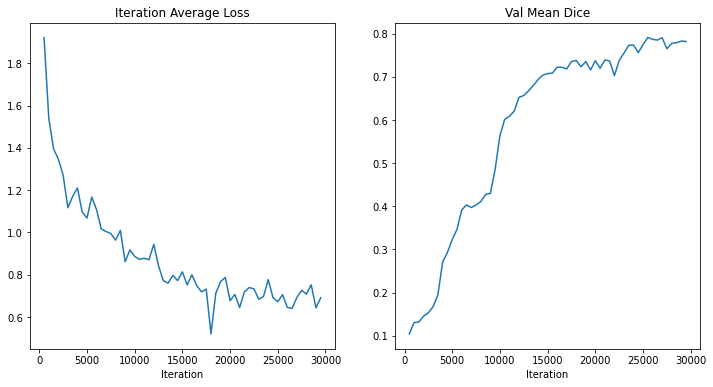

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
#30000

### Check best model output with the input image and label

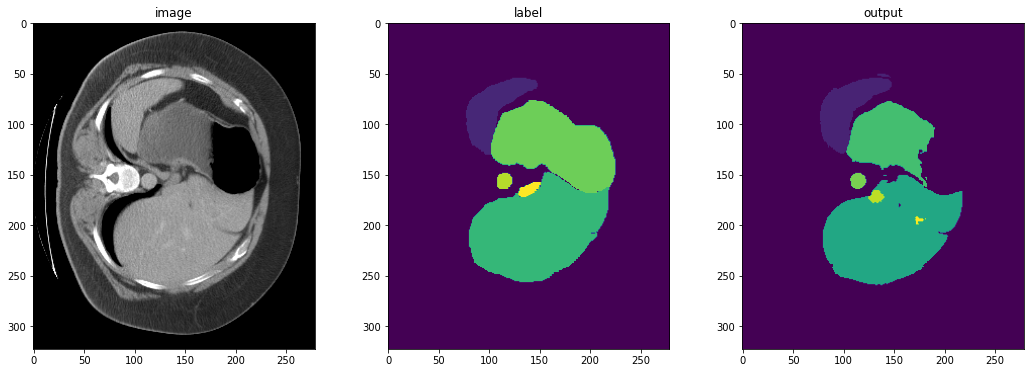

In [12]:
case_num = 3
model.load_state_dict(torch.load(os.path.join('.', "best_metric_model_20230816_30000.pth")))
model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]  # 이 줄을 삭제하고,
    file_path = val_ds[case_num]['image_meta_dict']['filename_or_obj']  # 이 줄을 추가합니다.
    img_name = os.path.basename(file_path)  # 파일명을 추출합니다.
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(torch.from_numpy(img), 1).cuda()
    val_labels = torch.unsqueeze(torch.from_numpy(label), 1).cuda()

    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()


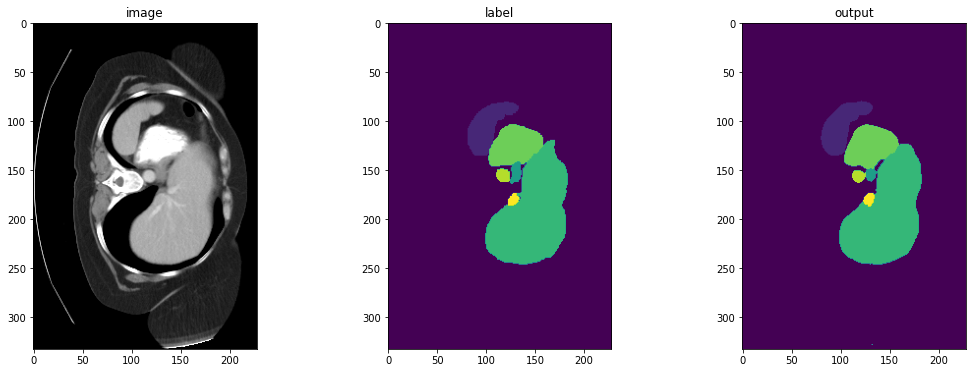

In [13]:
case_num = 4
model.load_state_dict(torch.load(os.path.join('.', "best_metric_model_20230816_30000.pth")))
model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]  # 이 줄을 삭제하고,
    file_path = val_ds[case_num]['image_meta_dict']['filename_or_obj']  # 이 줄을 추가합니다.
    img_name = os.path.basename(file_path)  # 파일명을 추출합니다.
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(torch.from_numpy(img), 1).cuda()
    val_labels = torch.unsqueeze(torch.from_numpy(label), 1).cuda()

    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()


### Cleanup data directory

Remove directory if a temporary was used.

In [14]:
'''if directory is None:
    shutil.rmtree(root_dir)'''

'if directory is None:\n    shutil.rmtree(root_dir)'

### HCC Dataset Visualization for Aorta Segmentation

In [15]:
# import glob
# import nibabel as nib
# import matplotlib.pyplot as plt
# import numpy as np

# plt.ion() # matplotlib의 interactive mode를 켬/ 주피터에서 시각화 보려면 켜야함

# # 한페이즈 불러오기(# 특정 패턴의 파일 불러오기/por로 끝나는거 다 가져옴)
# file_list = glob.glob('../../dataset/hyoreek/HCC/*_por_.nii.gz')

In [16]:
# # 처음 5개의 파일만 처리합니다.
# for file_path in file_list[:5]:  # 각 파일을 순회합니다.
#     proxy = nib.load(file_path)  # 해당 파일을 불러옵니다.
#     image = proxy.get_fdata()  # NIfTI 파일을 numpy array로 변환합니다.
    
#     # '페이즈' 또는 '슬라이스'의 30%에 해당하는 비율의 이미지를 보여줍니다.
#     plt.title("image")
#     plt.imshow(image[:, :, int(image.shape[2] * 0.3)], cmap='gray')  # 30% 위치 비율의 '페이즈' 또는 '슬라이스'를 시각화합니다.
#     plt.show()  # 시각화된 이미지를 보여줍니다.

In [17]:
# case_num = 5
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_20230814.pth")))
# model.eval()
# with torch.no_grad():
#     # img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]  # 이 줄을 삭제하고,
#     file_path = val_ds[case_num]['image_meta_dict']['filename_or_obj']  # 이 줄을 추가합니다.
#     img_name = os.path.basename(file_path)  # 파일명을 추출합니다.
#     img = val_ds[case_num]["image"]
#     label = val_ds[case_num]["label"]
#     val_inputs = torch.unsqueeze(torch.from_numpy(img), 1).cuda()
#     val_labels = torch.unsqueeze(torch.from_numpy(label), 1).cuda()

#     val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("image")
#     plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
#     plt.subplot(1, 3, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
#     plt.subplot(1, 3, 3)
#     plt.title("output")
#     plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
#     plt.show()